In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Listings_sin_atipicos.csv')
df= df.drop(['Unnamed: 0.1'], axis=1)
df= df.drop(['Unnamed: 0'], axis=1)
df.head(5)

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,days_since_first,months_since_first
0,https://www.airbnb.com/rooms/35797,2025-06-26,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,https://www.airbnb.com/users/show/153786,Dici,2010-06-28,...,4.90,4.90,4.80,1.0,1.0,0.0,0.0,0.00,887.0,29.200000
1,https://www.airbnb.com/rooms/44616,2025-07-01,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,No data,https://a0.muscache.com/pictures/251410/ec75fe...,https://www.airbnb.com/users/show/196253,Fernando,2010-08-09,...,4.78,4.98,4.47,9.0,4.0,2.0,0.0,0.39,4983.0,163.857534
2,https://www.airbnb.com/rooms/56074,2025-07-01,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,https://www.airbnb.com/users/show/265650,Maris,2010-10-19,...,4.94,4.76,4.79,1.0,1.0,0.0,0.0,0.48,887.0,29.200000
3,https://www.airbnb.com/rooms/67703,2025-07-01,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",No data,https://a0.muscache.com/pictures/3281720/6f078...,https://www.airbnb.com/users/show/334451,Nicholas,2011-01-04,...,4.92,4.98,4.92,2.0,2.0,0.0,0.0,0.30,4975.0,163.594521
4,https://www.airbnb.com/rooms/70644,2025-07-01,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,https://www.airbnb.com/users/show/212109,Trisha,2010-08-24,...,4.98,4.96,4.92,3.0,2.0,1.0,0.0,0.81,4886.0,160.668493


In [3]:
if "host_is_superhost" in df.columns:
    sup_map = {"t":1, "f":0, "true":1, "false":0, "True":1, "False":0, True:1, False:0}
    df["host_is_superhost"] = df["host_is_superhost"].map(sup_map).fillna(0).astype(int)

# b) convertir posibles objetos a numérico (los que no se puedan se vuelven NaN)
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# c) quedarnos sólo con columnas numéricas
df_num = df.select_dtypes(include=[np.number]).copy()

const_cols = df_num.columns[df_num.nunique(dropna=True) <= 1]
df_num.drop(columns=list(const_cols), inplace=True, errors="ignore")

In [4]:
targets = [
    "review_scores_rating",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_total_listings_count",
    "accommodates",
    "bedrooms",
    "price",                  # si en tu CSV está 'Price', cámbialo a 'price' arriba
    "review_scores_value",
    "bathrooms",
    "reviews_per_month",
]

In [5]:
df= df.drop(['days_since_first'], axis=1)
df= df.drop(['months_since_first'], axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def run_for_target(entire_df, yname):
    df_numeric = entire_df.drop(entire_df.select_dtypes(include=['object']).columns, axis=1)
    # X = todas las numéricas menos y
    features = [c for c in df_numeric.columns if c != yname]
    data = df_numeric[features + [yname]].copy()

    # 1) quitar filas donde y es NaN
    data = data.dropna(subset=[yname])

    # 2) imputar NaNs de X con la mediana (sencillo y robusto)
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(data[features])
    y = data[yname].values

    # 3) estandarizar X e y (para que los coef. sean comparables entre variables)
    sx = StandardScaler()
    sy = StandardScaler()
    Xs = sx.fit_transform(X)
    ys = sy.fit_transform(y.reshape(-1,1)).ravel()

    # 4) ajustar un modelo lineal múltiple simple (OLS)
    #    Como estandarizamos, ponemos fit_intercept=False (el intercepto queda ≈ 0).
    lr = LinearRegression(fit_intercept=False)
    lr.fit(Xs, ys)

    # 5) R² con validación cruzada (sólo para tener una medida de calidad)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_cv = cross_val_score(lr, Xs, ys, cv=kf, scoring="r2").mean()

    # 6) coeficientes estandarizados del modelo múltiple
    beta_std = pd.Series(lr.coef_, index=features, name="beta_std")

    # 7) correlaciones simples (equivalentes a “coef. lineal simple” del heatmap)
    #    Pearson entre cada columna de X (sin estandarizar) y y.
    X_df = pd.DataFrame(X, columns=features, index=data.index)
    corr_simple = X_df.corrwith(pd.Series(y, index=data.index))
    corr_simple.name = "corr_simple"

    # 8) armar tabla
    out = pd.concat([corr_simple, beta_std], axis=1)
    out = out.fillna(0.0)
    out["rank_abs_beta"] = out["beta_std"].abs().rank(ascending=False, method="dense")
    out["rank_abs_corr"] = out["corr_simple"].abs().rank(ascending=False, method="dense")
    out = out.sort_values(by="rank_abs_beta")

    return out, r2_cv

# === 4) Ejecutar para cada target y mostrar Top-10 =========
all_tabs = []
for y in targets:
    if y not in df_num.columns:
        print(f"⚠️ '{y}' no está en el DataFrame numérico. Se omite.")
        continue

    tab, r2 = run_for_target(df_num, y)
    print(f"Target: {y}  |  R² CV: {r2:.3f}")
    print(tab.head(10)[["corr_simple", "beta_std", "rank_abs_beta", "rank_abs_corr"]])

    t = tab.head(10).copy()
    t.insert(0, "target", y)
    t.insert(1, "r2_cv", round(r2, 3))
    all_tabs.append(t)

Target: review_scores_rating  |  R² CV: 0.704
                             corr_simple     beta_std  rank_abs_beta  \
months_since_first             -0.028311 -1734.856128            1.0   
days_since_first               -0.028309  1734.815334            2.0   
review_scores_accuracy          0.729541     0.325825            3.0   
review_scores_value             0.681655     0.244838            4.0   
review_scores_cleanliness       0.611621     0.173758            5.0   
review_scores_communication     0.619680     0.169179            6.0   
review_scores_checkin           0.557921     0.085251            7.0   
host_is_superhost               0.259227     0.051377            8.0   
review_scores_location          0.378321     0.041706            9.0   
reviews_per_month               0.000531    -0.037112           10.0   

                             rank_abs_corr  
months_since_first                    33.0  
days_since_first                      34.0  
review_scores_accuracy    

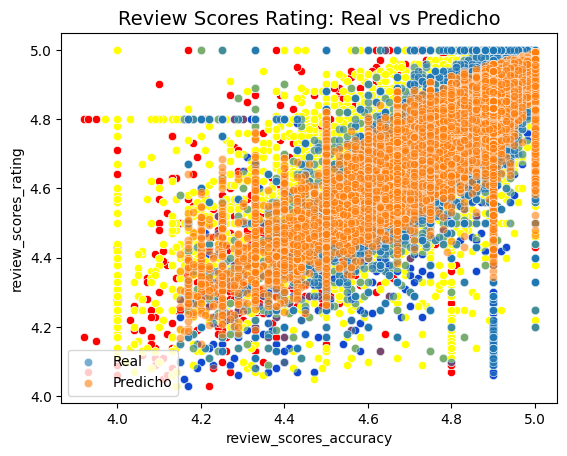

Coeficiente de Determinación (R²): 0.6927994907655044
Coeficiente de Correlación (R): 0.832345775964235


In [7]:
# 1. Visualizamos las variables predictoras contra la variable dependiente
sns.scatterplot(x='review_scores_accuracy', y='review_scores_rating', color="blue", data=df)
sns.scatterplot(x='review_scores_value', y='review_scores_rating', color="red", data=df)
sns.scatterplot(x='review_scores_cleanliness', y='review_scores_rating', color="yellow", data=df)

# 2. Declaramos las variables dependiente (Y) e independientes (X)
Vars_Indep = df[['review_scores_accuracy', 'review_scores_value', 'review_scores_cleanliness',
                 'review_scores_communication', 'review_scores_checkin', 
                 'host_is_superhost', 'review_scores_location', 'reviews_per_month']]

Var_Dep = df['review_scores_rating']

# 3. Definimos el modelo de regresión lineal
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# 4. Ajustamos el modelo con los datos
model.fit(X=Vars_Indep, y=Var_Dep)

# 5. Coeficientes obtenidos
model.__dict__

# 6. Coeficiente de determinación (R²)
model.score(Vars_Indep, Var_Dep)

# 7. Predicciones
y_pred = model.predict(X=Vars_Indep)

# 8. Insertamos las predicciones en el DataFrame
df.insert(0, 'Predicciones', y_pred)
df.head()

# Gráfica comparativa entre valores reales y predichos con colores más bonitos
sns.scatterplot(x='review_scores_accuracy', y='review_scores_rating', 
                color="#1f77b4", label="Real", alpha=0.6, data=df)  # Azul
sns.scatterplot(x='review_scores_accuracy', y='Predicciones', 
                color="#ff7f0e", label="Predicho", alpha=0.6, data=df)  # Naranja

plt.title("Review Scores Rating: Real vs Predicho", fontsize=14)
plt.xlabel("review_scores_accuracy")
plt.ylabel("review_scores_rating")
plt.legend()
plt.show()


# 10. Verificamos R² y coeficiente de correlación
coef_Deter = model.score(X=Vars_Indep, y=Var_Dep)
coef_Deter

coef_Correl = np.sqrt(coef_Deter)
coef_Correl

print("Coeficiente de Determinación (R²):", coef_Deter)
print("Coeficiente de Correlación (R):", coef_Correl)


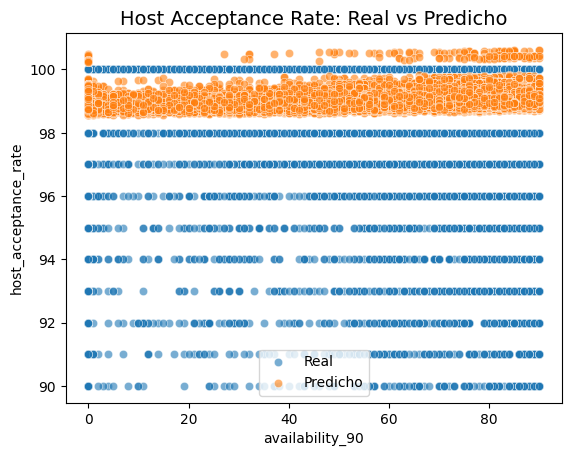

Coeficiente de Determinación (R²): 0.013888593757182655
Coeficiente de Correlación (R): 0.1178498780533211


In [8]:
from sklearn.impute import SimpleImputer

# Declaramos las variables independientes (predictoras) y dependiente (target)
Vars_Indep = df[['availability_90', 'availability_60', 'host_listings_count',
                 'estimated_occupancy_l365d', 'maximum_maximum_nights',
                 'minimum_maximum_nights', 'host_total_listings_count', 'host_id']]
Var_Dep = df['host_acceptance_rate']

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# Definimos el modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo
model.fit(X=Vars_Indep_imputed, y=Var_Dep)

# Obtenemos predicciones
y_pred = model.predict(X=Vars_Indep_imputed)

# Insertamos las predicciones en el DataFrame
df.insert(0, 'Predicciones2', y_pred)

# Visualizamos la gráfica comparativa entre valores reales y predichos
sns.scatterplot(x='availability_90', y='host_acceptance_rate', 
                color="#1f77b4", label="Real", alpha=0.6, data=df)  # Azul
sns.scatterplot(x='availability_90', y='Predicciones2', 
                color="#ff7f0e", label="Predicho", alpha=0.6, data=df)  # Naranja

plt.title("Host Acceptance Rate: Real vs Predicho", fontsize=14)
plt.xlabel("availability_90")
plt.ylabel("host_acceptance_rate")
plt.legend()
plt.show()

# Métricas del modelo
coef_Deter = model.score(X=Vars_Indep_imputed, y=Var_Dep)
coef_Correl = np.sqrt(coef_Deter)

print("Coeficiente de Determinación (R²):", coef_Deter)
print("Coeficiente de Correlación (R):", coef_Correl)

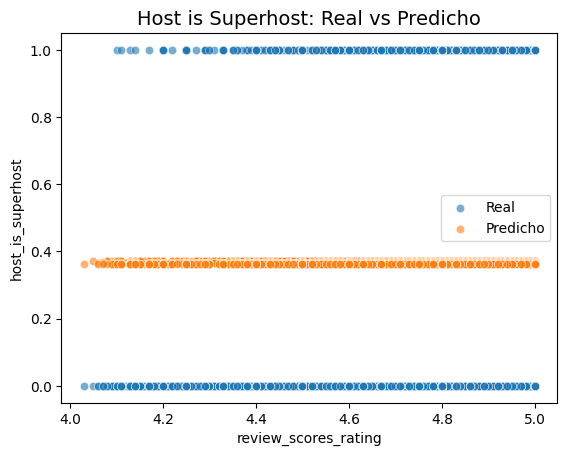

Coeficiente de Determinación (R²): 5.549325213694001e-05
Coeficiente de Correlación (R): 0.007449379312193735


In [9]:
# Variables independientes (sin days_since_first ni months_since_first)
Vars_Indep = df[['host_listings_count', 'host_host_total_listings_countname',
                 'estimated_occupancy_l365d', 'review_scores_rating',
                 'review_scores_communication', 'id',
                 'review_scores_cleanliness', 'maximum_nights_avg_ntm']]
Var_Dep = df['host_is_superhost']

from sklearn.impute import SimpleImputer

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# Definimos el modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo
model.fit(X=Vars_Indep_imputed, y=Var_Dep)

# Obtenemos predicciones
y_pred = model.predict(X=Vars_Indep_imputed)

# Insertamos las predicciones en el DataFrame
df.insert(0, 'Predicciones3', y_pred)

# Visualización comparativa entre Real vs Predicho
sns.scatterplot(x='review_scores_rating', y='host_is_superhost', 
                color="#1f77b4", label="Real", alpha=0.6, data=df)  # Azul
sns.scatterplot(x='review_scores_rating', y='Predicciones3', 
                color="#ff7f0e", label="Predicho", alpha=0.6, data=df)  # Naranja

plt.title("Host is Superhost: Real vs Predicho", fontsize=14)
plt.xlabel("review_scores_rating")
plt.ylabel("host_is_superhost")
plt.legend()
plt.show()

# Métricas del modelo
coef_Deter = model.score(X=Vars_Indep_imputed, y=Var_Dep)
coef_Correl = np.sqrt(coef_Deter)

print("Coeficiente de Determinación (R²):", coef_Deter)
print("Coeficiente de Correlación (R):", coef_Correl)

np.float64(0.4476135379976364)

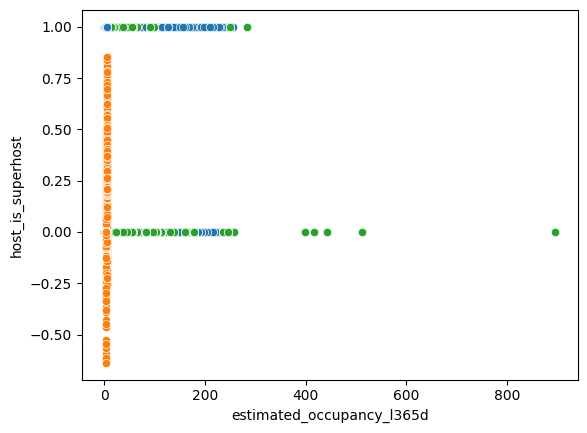

In [10]:
# Gráficas exploratorias (3 predictoras) con colores agradables
sns.scatterplot(x='estimated_occupancy_l365d', y='host_is_superhost', color="#1f77b4", data=df)  # azul
sns.scatterplot(x='review_scores_rating',      y='host_is_superhost', color="#ff7f0e", data=df)  # naranja
sns.scatterplot(x='host_listings_count',       y='host_is_superhost', color="#2ca02c", data=df)  # verde

# Declaramos variables dependiente e independientes para la regresión lineal
Vars_Indep = df[['estimated_occupancy_l365d', 'review_scores_rating', 'host_listings_count']]
Var_Dep   = df['host_is_superhost']

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# Se define model como la función de regresión lineal
model = LinearRegression()

# Ajustamos el modelo con las variables antes declaradas
model.fit(X=Vars_Indep_imputed, y=Var_Dep)

# Verificamos los coeficientes obtenidos para el modelo ajustado
model.__dict__

# Predecimos los valores del target a partir de las variables seleccionadas
y_pred = model.predict(X=Vars_Indep_imputed)
y_pred

# Insertamos la columna de predicciones en el DataFrame
df.insert(0, 'Predicciones4', y_pred)
df

# Visualizamos la gráfica comparativa entre el valor real y el predicho
sns.scatterplot(x='review_scores_rating', y='host_is_superhost', color="#1f77b4", data=df)   # Real
sns.scatterplot(x='review_scores_rating', y='Predicciones4',      color="#ff7f0e", data=df)   # Predicho

# Corroboramos el coeficiente de Determinación del modelo
coef_Deter = model.score(X=Vars_Indep_imputed, y=Var_Dep)
coef_Deter

# Corroboramos el coeficiente de Correlación del modelo
coef_Correl = np.sqrt(coef_Deter)
coef_Correl



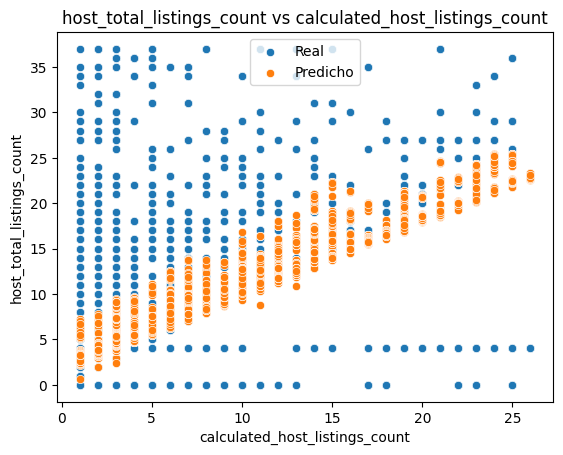

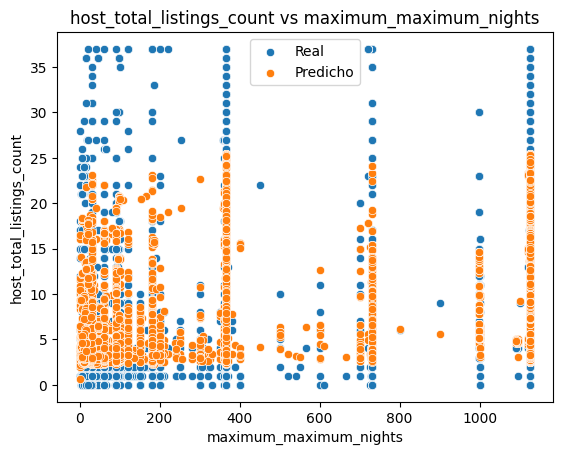

R² (train): 0.400
Coef. de correlación ≈ 0.632
Coeficientes: {'calculated_host_listings_count': np.float64(0.7929946495854284), 'maximum_maximum_nights': np.float64(0.003949912310806559), 'calculated_host_listings_count_entire_homes': np.float64(0.2703571992583825), 'minimum_maximum_nights': np.float64(-0.002009244583944303), 'maximum_nights_avg_ntm': np.float64(-0.0016936286809035635), 'availability_60': np.float64(0.02133663557378167), 'availability_90': np.float64(-0.008575070264029384)}


In [11]:

# === 1) Variables ===
# (todas numéricas; NO incluimos months_since_first ni days_since_first)
Vars_Indep = df[[
    'calculated_host_listings_count',
    'maximum_maximum_nights',
    'calculated_host_listings_count_entire_homes',
    'minimum_maximum_nights',
    'maximum_nights_avg_ntm',
    'availability_60',
    'availability_90'
]]

Var_Dep = df['host_total_listings_count']

# === 2) Modelo lineal ===
model = LinearRegression()
model.fit(X=Vars_Indep, y=Var_Dep)

# === 3) Predicciones e inserción ===
y_pred = model.predict(Vars_Indep)
col_pred = 'Predicciones_host_total_listings_count'
if col_pred in df.columns:
    df.drop(columns=[col_pred], inplace=True)
df.insert(0, col_pred, y_pred)

# === 4) Gráficas comparativas (colores bonitos) ===
palette_real   = "#1f77b4"  # azul
palette_pred   = "#ff7f0e"  # naranja

# a) vs calculated_host_listings_count
sns.scatterplot(x='calculated_host_listings_count', y='host_total_listings_count',
                color=palette_real, data=df, label="Real")
sns.scatterplot(x='calculated_host_listings_count', y=col_pred,
                color=palette_pred, data=df, label="Predicho")
plt.title("host_total_listings_count vs calculated_host_listings_count")
plt.legend(); plt.show()

# b) vs maximum_maximum_nights
sns.scatterplot(x='maximum_maximum_nights', y='host_total_listings_count',
                color=palette_real, data=df, label="Real")
sns.scatterplot(x='maximum_maximum_nights', y=col_pred,
                color=palette_pred, data=df, label="Predicho")
plt.title("host_total_listings_count vs maximum_maximum_nights")
plt.legend(); plt.show()

# === 5) Métricas rápidas ===
r2 = model.score(Vars_Indep, Var_Dep)
corr = np.sqrt(r2) if r2 >= 0 else np.nan
print(f"R² (train): {r2:.3f}")
print(f"Coef. de correlación ≈ {corr:.3f}")

# (Opcional) ver coeficientes estandarizados rápidos
betas = dict(zip(Vars_Indep.columns, model.coef_))
print("Coeficientes:", betas)


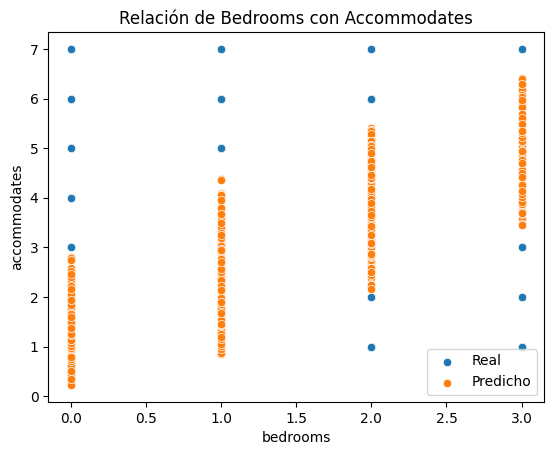

Coeficiente de Determinación (R²): 0.5394859177966556
Coeficiente de Correlación: 0.7344970509107954


In [12]:
# Variables independientes (sin days_since_first ni months_since_first)
Vars_Indep = df[['bedrooms', 'beds', 'price', 'availability_90',
                 'availability_60', 'calculated_host_listings_count_private_rooms',
                 'maximum_nights_avg_ntm', 'estimated_revenue_l365d']]

# Variable dependiente
Var_Dep = df['accommodates']

# Definimos el modelo
model = LinearRegression()
# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)
# Ajustamos el modelo
model.fit(X=Vars_Indep, y=Var_Dep)

# Predicciones
y_pred = model.predict(X=Vars_Indep)

# Insertamos las predicciones al DataFrame
df.insert(0, 'Predicciones_accommodates', y_pred)

# Gráficas comparativas con colores más bonitos
palette = ["#1f77b4", "#ff7f0e"]  # Azul y naranja estilo elegante

# Ejemplo gráfico con bedrooms
sns.scatterplot(x='bedrooms', y='accommodates', color=palette[0], data=df, label="Real")
sns.scatterplot(x='bedrooms', y='Predicciones_accommodates', color=palette[1], data=df, label="Predicho")
plt.title("Relación de Bedrooms con Accommodates")
plt.legend()
plt.show()

# Coeficiente de determinación
coef_Deter = model.score(X=Vars_Indep, y=Var_Dep)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)


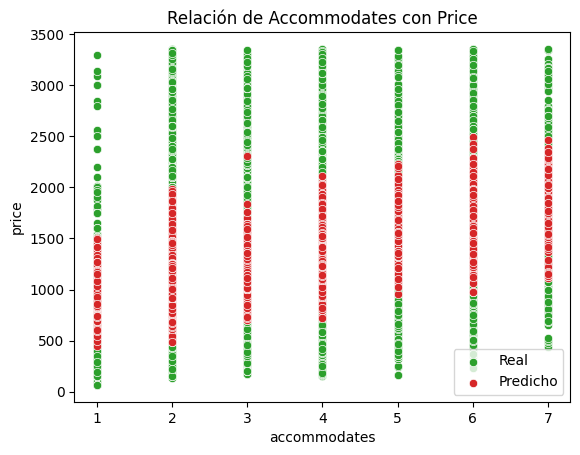

Coeficiente de Determinación (R²): 0.20304959850565962
Coeficiente de Correlación: 0.45061025122122955


In [13]:
# Variables independientes (sin days_since_first ni months_since_first)
Vars_Indep = df[['accommodates', 'estimated_revenue_l365d', 'estimated_occupancy_l365d',
                 'maximum_minimum_nights', 'bedrooms', 'maximum_maximum_nights',
                 'availability_90', 'bathrooms']]

# Variable dependiente
Var_Dep = df['price']

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# Definimos el modelo
model = LinearRegression()

# Ajustamos el modelo
model.fit(X=Vars_Indep, y=Var_Dep)

# Predicciones
y_pred = model.predict(X=Vars_Indep)

# Insertamos las predicciones al DataFrame
df.insert(0, 'Predicciones_price', y_pred)

# Gráficas comparativas con colores elegantes
palette = ["#2ca02c", "#d62728"]  # Verde y rojo elegante

# Ejemplo gráfico con accommodates
sns.scatterplot(x='accommodates', y='price', color=palette[0], data=df, label="Real")
sns.scatterplot(x='accommodates', y='Predicciones_price', color=palette[1], data=df, label="Predicho")
plt.title("Relación de Accommodates con Price")
plt.legend()
plt.show()

# Coeficiente de determinación
coef_Deter = model.score(X=Vars_Indep, y=Var_Dep)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)

Coeficientes (beta):
  accommodates                         0.193014
  bathrooms                            0.343272
  beds                                 0.109123
  maximum_nights_avg_ntm               0.000058
  price                                0.000091
  minimum_maximum_nights              -0.000070
  host_listings_count                 -0.000153
  calculated_host_listings_count      -0.007521


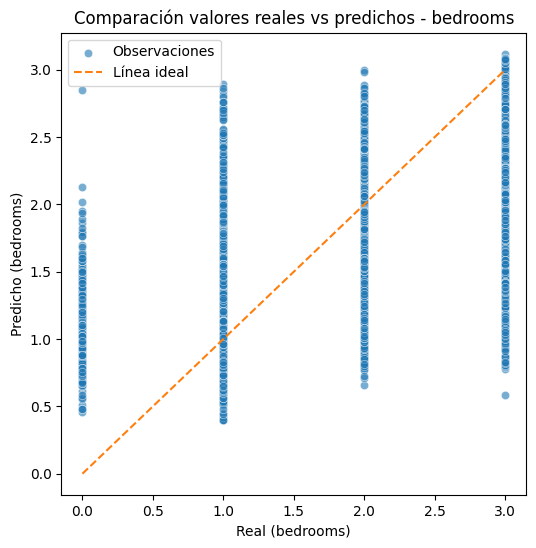

Coeficiente de Determinación (R²): 0.531898340235518
Coeficiente de Correlación: 0.7293136089745741


In [14]:
Vars_Indep = df[[
    'accommodates',
    'bathrooms',
    'beds',
    'maximum_nights_avg_ntm',
    'price',
    'minimum_maximum_nights',
    'host_listings_count',
    'calculated_host_listings_count'
]]
Var_Dep = df['bedrooms']

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# =========================
# 2) Entrenamiento
# =========================
model = LinearRegression()
model.fit(Vars_Indep_imputed, Var_Dep)

# =========================
# 3) Predicción y columna
# =========================
y_pred = model.predict(Vars_Indep_imputed)
col_pred = 'Predicciones_bedrooms'
if col_pred in df.columns:
    df.drop(columns=[col_pred], inplace=True)
df.insert(0, col_pred, y_pred)

# Coeficientes por variable (por si quieres revisarlos)
print("Coeficientes (beta):")
for v, b in zip(Vars_Indep.columns, model.coef_):
    print(f"  {v:35s} {b: .6f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=Var_Dep, y=y_pred, color="#1f77b4", alpha=0.6, label="Observaciones")
plt.plot([Var_Dep.min(), Var_Dep.max()],
         [Var_Dep.min(), Var_Dep.max()],
         color="#ff7f0e", linestyle="--", label="Línea ideal")

plt.xlabel("Real (bedrooms)")
plt.ylabel("Predicho (bedrooms)")
plt.title("Comparación valores reales vs predichos - bedrooms")
plt.legend()
plt.show()

# Coeficiente de determinación
coef_Deter = model.score(X=Vars_Indep_imputed, y=Var_Dep)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)

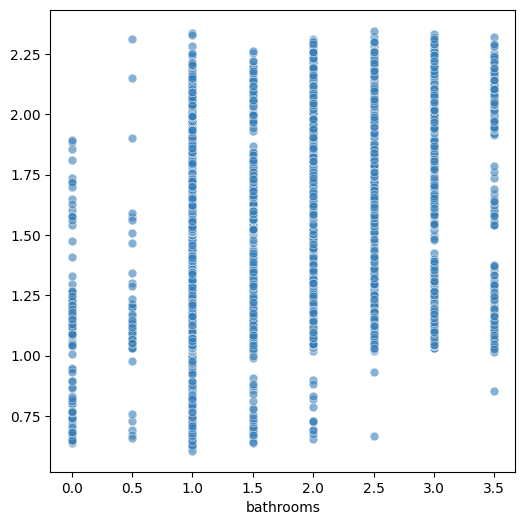

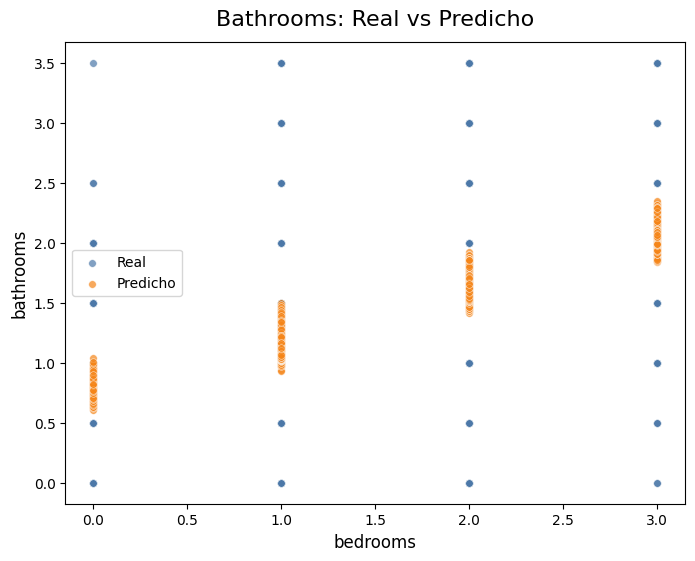

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# ======================
# Variables independientes y dependiente
# ======================
Vars_Indep = df[['bedrooms', 'price', 'accommodates', 
                 'maximum_nights_avg_ntm', 'minimum_nights',
                 'maximum_maximum_nights', 'estimated_revenue_l365d',
                 'calculated_host_listings_count']]

Var_Dep = df['bathrooms']

# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)

# ======================
# Ajustar modelo
# ======================
model = LinearRegression()
model.fit(X=Vars_Indep_imputed, y=Var_Dep)

# ======================
# Predicciones
# ======================
y_pred = model.predict(X=Vars_Indep_imputed)
df.insert(0, 'Pred_bathrooms', y_pred)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Var_Dep, y=y_pred, color="#377eb8", alpha=0.6, s=40)

plt.figure(figsize=(8,6))

# Puntos reales (azules)
sns.scatterplot(
    x=df[Vars_Indep.columns[0]],  # puedes cambiar el eje X según convenga
    y=Var_Dep,
    color="#4C78A8", s=30, alpha=0.7, label="Real"
)

# Puntos predichos (naranjas)
sns.scatterplot(
    x=df[Vars_Indep.columns[0]],
    y=y_pred,
    color="#F58518", s=30, alpha=0.7, label="Predicho"
)

plt.title(f"{Var_Dep.name.replace('_',' ').title()}: Real vs Predicho", fontsize=16, pad=12)
plt.xlabel(Vars_Indep.columns[0], fontsize=12)
plt.ylabel(Var_Dep.name, fontsize=12)
plt.legend()
plt.show()

In [16]:
# Coeficiente de determinación
coef_Deter = model.score(X=Vars_Indep_imputed, y=Var_Dep)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)

Coeficiente de Determinación (R²): 0.29486400154920156
Coeficiente de Correlación: 0.5430138134055169


R² = 0.006


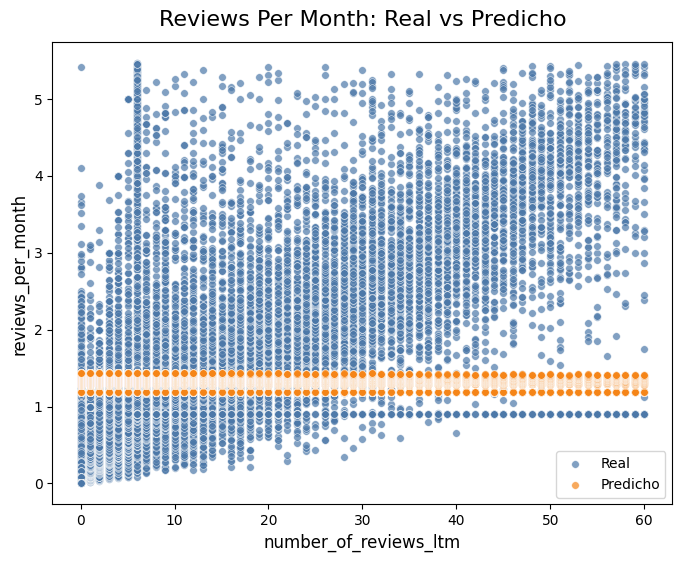

Coeficiente de Determinación (R²): 0.005505249326954065
Coeficiente de Correlación: 0.07419736738560247


In [19]:
target = "reviews_per_month"
features = [
    "number_of_reviews_ltm", "estimated_occupancy_l365d", "id",
    "number_of_reviews",
    "minimum_nights_avg_ntm", "review_scores_value"
]
# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)
# ========== REGRESIÓN ==========
X = df[features]
y = df[target]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Insertamos predicciones en el DataFrame
df["Predicciones7"] = y_pred

# Evaluación del modelo
r2 = model.score(X, y)
print(f"R² = {r2:.3f}")

# ========== GRÁFICA ==========
plt.figure(figsize=(8,6))

# Puntos reales (azules)
sns.scatterplot(
    x=df[features[0]],  # Usamos la primera variable como eje X (puedes cambiarla)
    y=y,
    color="#4C78A8", s=30, alpha=0.7, label="Real"
)

# Puntos predichos (naranjas)
sns.scatterplot(
    x=df[features[0]],
    y=y_pred,
    color="#F58518", s=30, alpha=0.7, label="Predicho"
)

plt.title(f"{target.replace('_',' ').title()}: Real vs Predicho", fontsize=16, pad=12)
plt.xlabel(features[0], fontsize=12)
plt.ylabel(target, fontsize=12)
plt.legend()
plt.show()

# Coeficiente de determinación
coef_Deter = model.score(X, y)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)

R² = 0.518


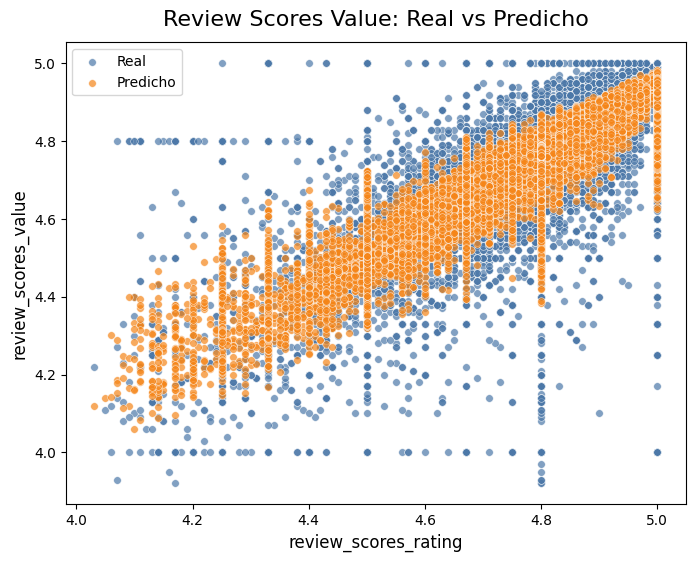

Coeficiente de Determinación (R²): 0.5184816736179974
Coeficiente de Correlación: 0.7200567155564882


In [20]:

# ========== CONFIGURACIÓN ==========
target = "review_scores_value"
features = [
    "review_scores_rating", "review_scores_accuracy", 
    "review_scores_cleanliness", "review_scores_location",
    "reviews_per_month", "availability_90", 
    "estimated_occupancy_l365d", "review_scores_communication"
]
# Imputar NaNs en las variables independientes con la mediana
imputer = SimpleImputer(strategy="median")
Vars_Indep_imputed = imputer.fit_transform(Vars_Indep)
# ========== REGRESIÓN ==========
X = df[features]
y = df[target]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Insertamos predicciones en el DataFrame
df["Predicciones8"] = y_pred

# Evaluación del modelo
r2 = model.score(X, y)
print(f"R² = {r2:.3f}")

# ========== GRÁFICA ==========
plt.figure(figsize=(8,6))

# Puntos reales (azules)
sns.scatterplot(
    x=df[features[0]],  # Usamos la primera variable como eje X
    y=y,
    color="#4C78A8", s=30, alpha=0.7, label="Real"
)

# Puntos predichos (naranjas)
sns.scatterplot(
    x=df[features[0]],
    y=y_pred,
    color="#F58518", s=30, alpha=0.7, label="Predicho"
)

plt.title(f"{target.replace('_',' ').title()}: Real vs Predicho", fontsize=16, pad=12)
plt.xlabel(features[0], fontsize=12)
plt.ylabel(target, fontsize=12)
plt.legend()
plt.show()
# Coeficiente de determinación
coef_Deter = model.score(X, y)
print("Coeficiente de Determinación (R²):", coef_Deter)

# Coeficiente de correlación
coef_Correl = np.sqrt(coef_Deter)
print("Coeficiente de Correlación:", coef_Correl)